# Zadanie nr 1.2.2 - Implementacja propagacji wstecznej błędu
## Metody Inteligencji Obliczeniowej w Analizie Danych
### Paweł Koźmiński, 298825

Zakres drugiego laboratorium punktowanego obejmował rozszerzenie dotychczasowej implementacji sieci MLP. Zadanie można podzielić na kilka etapów. Po pierwsze, należało zaimplementować algorytm propagacji wstecznej błędu wewnątrz modelu przy pomocy narzędzi przedstawionych w trakcie wykładu. Po drugie, w celu inicjalizacji możliwie dobrych wag początkowy sieci, zaproponowano użycie metod He, Xaviera oraz losowania wag z przedziału jednostajnego. Ponadto ciekawym wyzwaniem okazała się próba stworzenia wizualizacji sieci wraz z wagami po każdej ich korekcie.
W celu stworzenia rozwiązania ostatniego zadania skorzystałem z biblioteki networkx, która zaimportowałem wraz z innymi potrzebnymi:

In [3]:
import math
import numpy as np
from scipy.misc import derivative
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
import networkx as nx

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
class Net:
    def __init__(self, n_inputs, hidden_neurons_n, n_outputs, weights, hidden_activation_fun, last_activation_fun, uniform_weights_limits = (-1, 1)):
        """
        Constructor of object Net takes many arguments required for building a model:
        n_inputs - number of inputs to the net
        hidden_neurons_n - list of integers pointing the size of hidden layers
        n_outputs - expected size of output
        weights - a string, one of "He", "Xavier", "Uniform", depending on desired method of drawing the initializing weights.
        The possibility of manually input the weights has been disactivated.
        hidden_activation_fun - activation function used in hidden layers
        last_activation_fun - activation function used in last layer
        uniform_weights_limits - a tuple, used only if weights = "Uniform", indicating the parameters (lower, upper) of the uniform distribution to draw the weights from.
        
        """
        Layers = [self.Layer(n_inputs, hidden_neurons_n[0], weights, None, hidden_activation_fun, uniform_weights_limits)]
        Layers = Layers + [self.Layer(hidden_neurons_n[j], hidden_neurons_n[j+1], weights, None, hidden_activation_fun,
                                       uniform_weights_limits) for j in range(len(hidden_neurons_n)-1)]
        Layers = Layers + [self.Layer(hidden_neurons_n[-1], n_outputs, weights, None, last_activation_fun, uniform_weights_limits)]
        self.layers_list = Layers
        self.layers_size = [n_inputs] + hidden_neurons_n + [n_outputs]
        
    def train(self, data, learning_rate=0.005, epochs=5, batch_size = 1, plot = True, verbose = True):
        """
        data - numpy.array of numpy arrays of shape (2, ...) where first element is the input and the second is output.
        Due to the structure of numpy array, both inputs and labels need to be of the same length. Please fill the shorter one with any values just to align it.
        Only first <n_inputs> or <n_outputs> will be taken into consideration.
        batch_size - number of observations presented to the net in one iteration. When batch_size>len(data) it is minimised to len(data)
        """
        #create net graph
        if plot:
            G = nx.Graph()
            G.add_nodes_from(range(sum(self.layers_size)))
            #add edges to graph
            pom = 0
            pom2 = 0
            for k in range(len(self.layers_size)-1):
                pom += self.layers_size[k]
                for i in range(pom2, pom):
                    for j in range(pom, pom+self.layers_size[k+1]):
                        G.add_edge(i, j)
                pom2 += self.layers_size[k]
        #let's train:
        for k in range(epochs):
            if verbose: print(f"Epoch {k+1} out of {epochs} ({round((k)/epochs*100)}%)")
            
            for n_batch in range(0, len(data), batch_size):
                cur_data = data[n_batch:(min((n_batch+batch_size), len(data))),:,:] #slicing the data to batch
                changing_x = cur_data[:,0, 0:self.layers_size[0]] #independent values
                expected_y = cur_data[:,1,0:self.layers_size[len(self.layers_size)-1]] #target
                
                for i in range(0, len(self.layers_list)): #feed forward
                    changing_x = self.layers_list[i].go(changing_x)

                for i in range(len(self.layers_list)-1, -1, -1): #back propagation
                    if i == len(self.layers_list)-1: #the last layer is a little bit different
                        self.layers_list[i].err = (changing_x-expected_y)\
                        *derivative(self.layers_list[i].activation_fun, self.layers_list[i].activation_argument, dx = 1e-10)
                    if i>0: #other layers
                        self.layers_list[i-1].err = np.dot(self.layers_list[i].err, np.transpose(self.layers_list[i].weights))\
                        *derivative(self.layers_list[i-1].activation_fun, self.layers_list[i-1].activation_argument, dx = 1e-10)

                for i in range(len(self.layers_list)-1, -1, -1): # weights correction
                    weights_delta = -1 * learning_rate * np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                    bias_delta = (-1 * learning_rate * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                    bias_delta = np.mean(bias_delta, axis = 0)
                    self.layers_list[i].weights += weights_delta
                    self.layers_list[i].bias += bias_delta.reshape(-1,)
            #add weights to the graph plot
            if plot:
                edge_labels = dict()
                for z in range(0, len(self.layers_size)-1):
                    edge_labels = {**edge_labels, **{(i, j): round(self.layers_list[z].weights[i-(0 if z==0 else np.cumsum(self.layers_size)[z-1]),j-np.cumsum(self.layers_size)[z]], 2)
                                    for i in range(0 if z==0 else np.cumsum(self.layers_size)[z-1],np.cumsum(self.layers_size)[z])
                                    for j in range(np.cumsum(self.layers_size)[z],np.cumsum(self.layers_size)[z+1])}}
                plt.figure(figsize = (10, 6))
                # nodes position:
                pos = {j: (p, 1/(self.layers_size[p]+1)*(j-(0 if p==0 else np.cumsum(self.layers_size)[p-1])+1)) 
                                    for p in range(len(self.layers_size))
                                    for j in range(0 if p==0 else np.cumsum(self.layers_size)[p-1], np.cumsum(self.layers_size)[p])}
                nx.draw_networkx(G, pos, alpha = 0.9, with_labels=False)
                #Displaying edge labels on different positions:
                edge_labels_list = list(edge_labels.items())
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[::4]), label_pos = 0.2, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[1::4]), label_pos = 0.4, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[2::4]), label_pos = 0.6, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[3::4]), label_pos = 0.8, font_color = 'red')
                plt.show()
        #finally, return the predicted output:
        changing_x = data[:,0,:] 
        for i in range(0, len(self.layers_list)): #feed forward
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x
    def predict(self, x):
        """
        x - numpy array of inputs to be predicted by (assumably already trained) Net
        """
        changing_x = x
        for i in range(0, len(self.layers_list)):
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x
    
    class Layer:
        def __init__(self, n_inputs, neurons, weights, bias, activation_fun, uniform_weights_limits=(-1, 1)):
            """
            The constructor of Layer class takes as arguments:
            n_inputs - number of inputs into a layer,
            neurons - number of layers in a layer,
            weights - weights of inputs of a layer - highly recommended for weights to be of class numpy.array or "He"/"Xavier"/"Uniform"
            bias - values of bias - preferably numpy.array as well,
            activation - activation function (possibly lambda function) 
            """
            self.neurons = neurons
            self.n_inputs = n_inputs
            self.activation_fun = activation_fun
            if weights == "He":
                weights = np.random.normal(scale=np.sqrt(2/n_inputs), size = (n_inputs, neurons))
                bias = np.random.normal(scale=np.sqrt(2/n_inputs), size = (neurons,))
            elif weights == "Xavier":
                weights = np.random.uniform(-1*np.sqrt(1/(n_inputs)), np.sqrt(1/(n_inputs)), size = (n_inputs, neurons))
                bias = np.random.uniform(-1*np.sqrt(1/(n_inputs)), np.sqrt(1/(n_inputs)), size = (neurons,))
            elif weights == "Uniform":
                weights = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (n_inputs, neurons))
                bias = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (neurons,))
            if len(weights.shape) == 1:
                weights = weights.reshape(1, -1)
            if weights.shape == (n_inputs, neurons):
                self.weights = weights
            else:
                raise AttributeError("The dimensions of weights are not aligned")
            if len(weights.shape) == 1:
                if len(bias) == len(weights):
                    self.bias = bias
            elif len(bias) == weights.shape[1]:
                self.bias = bias
            else:
                raise AttributeError("Incorrect length of bias")
            self.activation_argument = None
            self.err = None
            self.out_value = None
            self.input_values = None
        def go(self, x_input):
            """
            x_input - numpy.array containing data used in a layer.
            """
            if x_input.shape[1] != self.n_inputs:
                raise AttributeError("The dimensions of input are incorrect for this layer")
            self.input_values = x_input
            self.activation_argument = np.dot(x_input, self.weights) + self.bias
            self.out_value = self.activation_fun(self.activation_argument)
            return self.out_value

# Pierwszy zbiór danych: square-simple

In [6]:
train_df = pd.read_csv('../dane/mio1/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../dane/mio1/regression/square-simple-test.csv', index_col=0)
train_df
first_scaler = preprocessing.StandardScaler().fit(train_df)
scaled_train_df = first_scaler.transform(train_df)
scaled_test_df = first_scaler.transform(test_df)
train_data = np.array([
    np.array([[x_i], [y_i]])
    for x_i, y_i in zip(
        scaled_train_df[:,0],
        scaled_train_df[:,1]
    )
])

In [7]:
train_data.shape # 100 observations, x and y 1D

(100, 2, 1)

Epoch 1 out of 3 (0%)


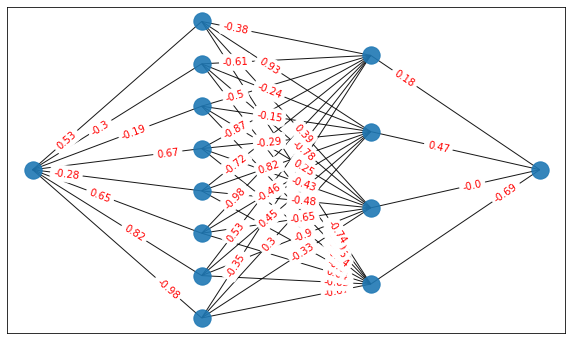

Epoch 2 out of 3 (33%)


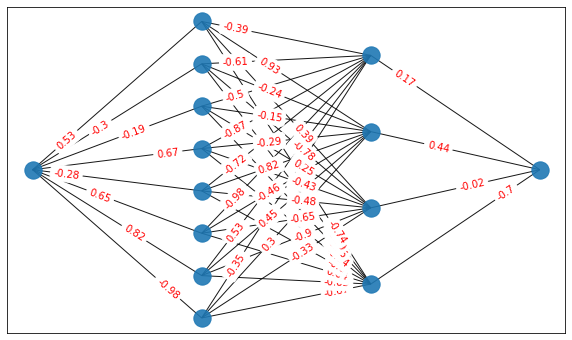

Epoch 3 out of 3 (67%)


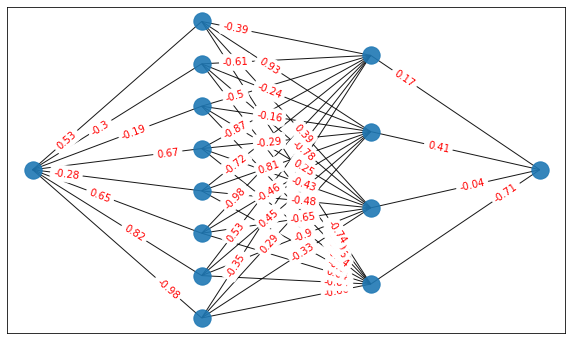

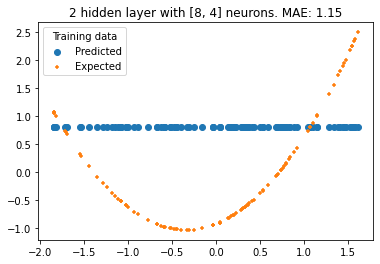

In [11]:
hidden_layers = [8, 4]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data, learning_rate=0.005, epochs = 3, batch_size = 10, plot = True)
plt.scatter(scaled_train_df[:, 0], y_pred.reshape(-1, 1), label = 'Predicted')
plt.scatter(scaled_train_df[:, 0], scaled_train_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Training data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_pred, scaled_train_df[:, 1]), 2)}')
plt.show()

Epoch 1 out of 50 (0%)


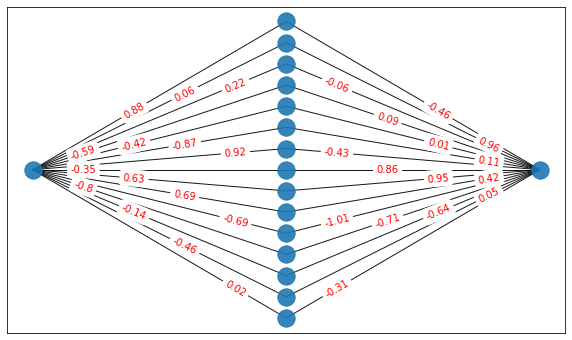

Epoch 2 out of 50 (2%)


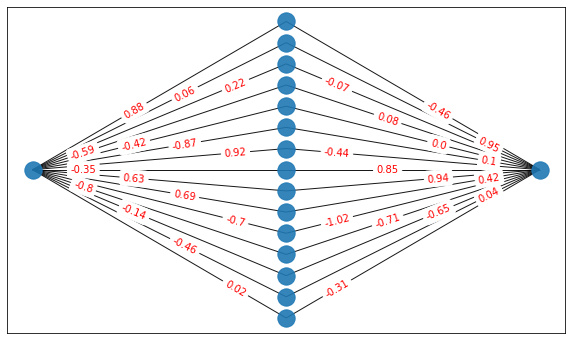

Epoch 3 out of 50 (4%)


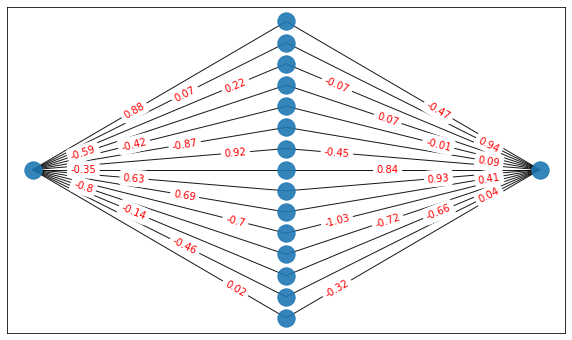

Epoch 4 out of 50 (6%)


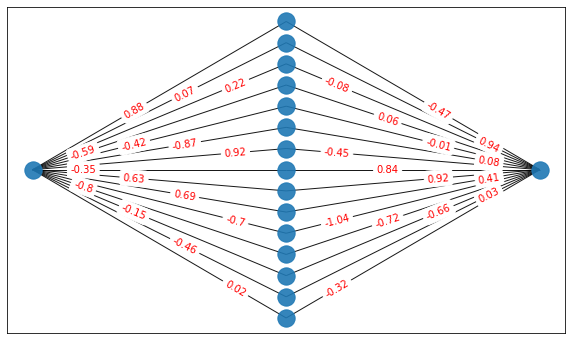

Epoch 5 out of 50 (8%)


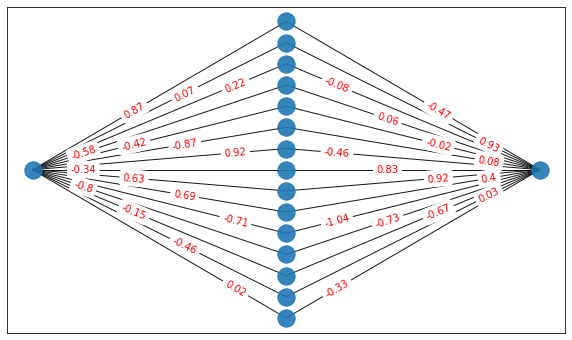

Epoch 6 out of 50 (10%)


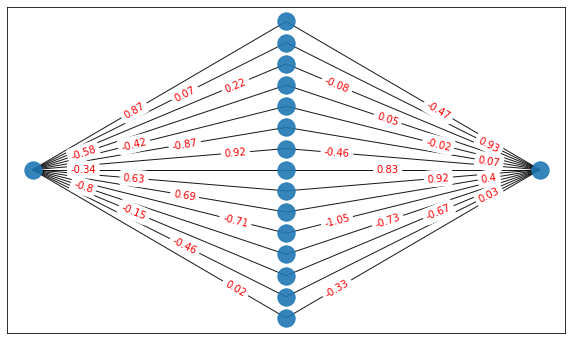

Epoch 7 out of 50 (12%)


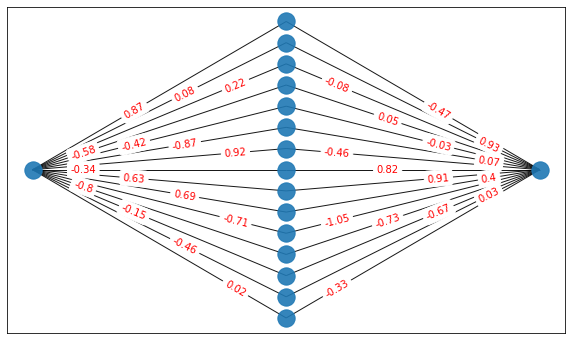

Epoch 8 out of 50 (14%)


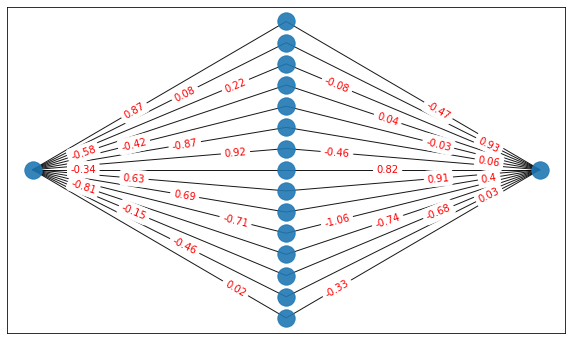

Epoch 9 out of 50 (16%)


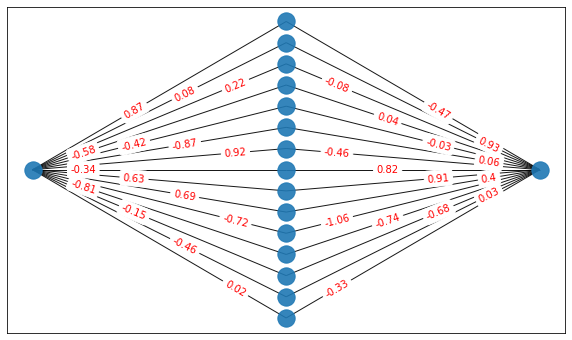

Epoch 10 out of 50 (18%)


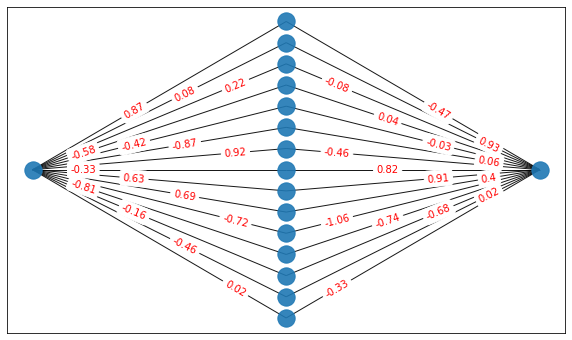

Epoch 11 out of 50 (20%)


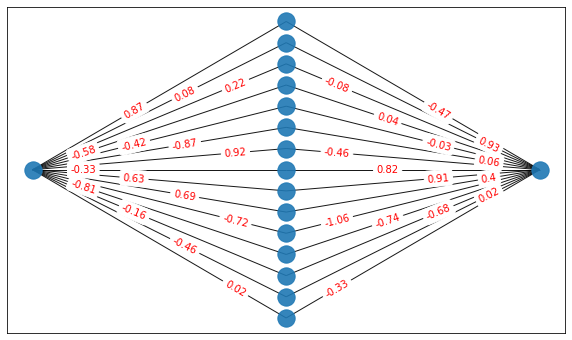

Epoch 12 out of 50 (22%)


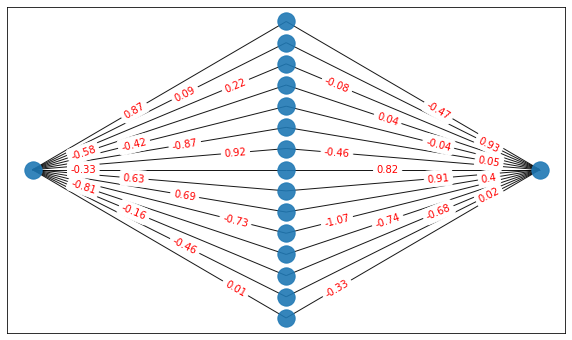

Epoch 13 out of 50 (24%)


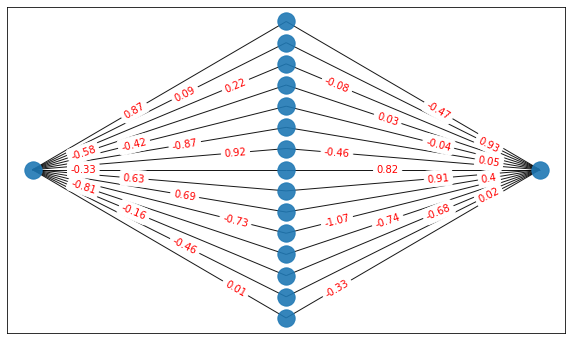

Epoch 14 out of 50 (26%)


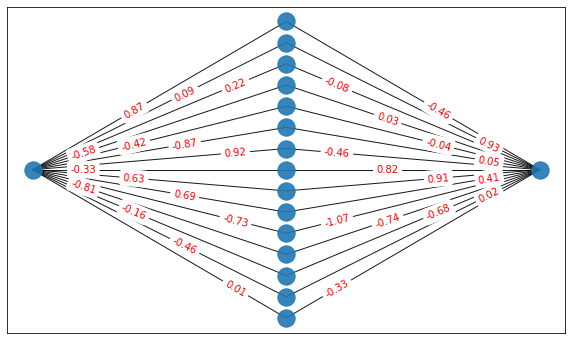

Epoch 15 out of 50 (28%)


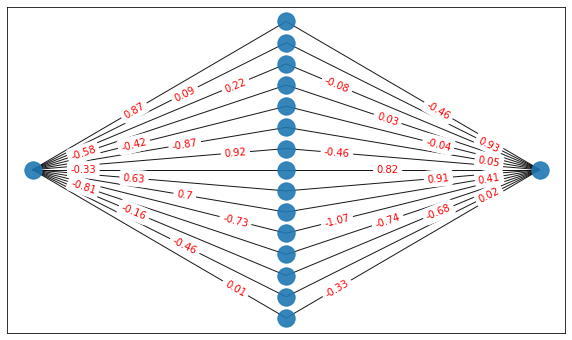

Epoch 16 out of 50 (30%)


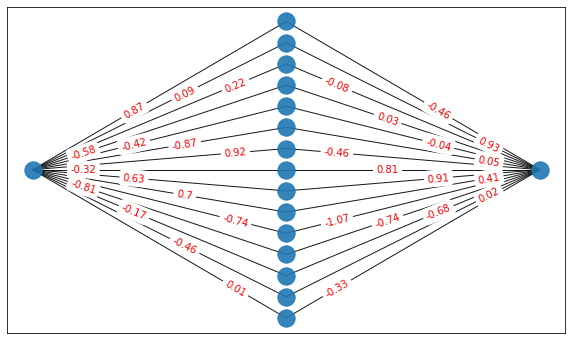

Epoch 17 out of 50 (32%)


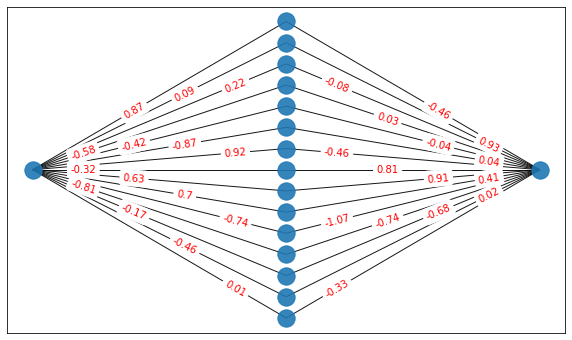

Epoch 18 out of 50 (34%)


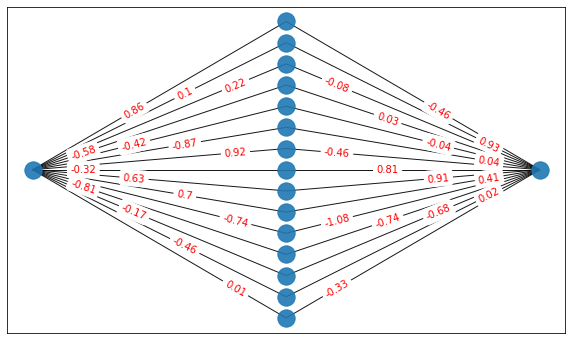

Epoch 19 out of 50 (36%)


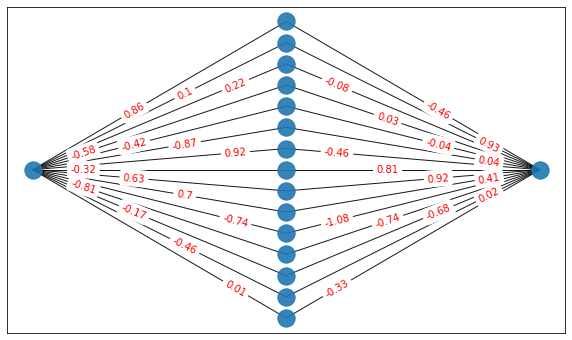

Epoch 20 out of 50 (38%)


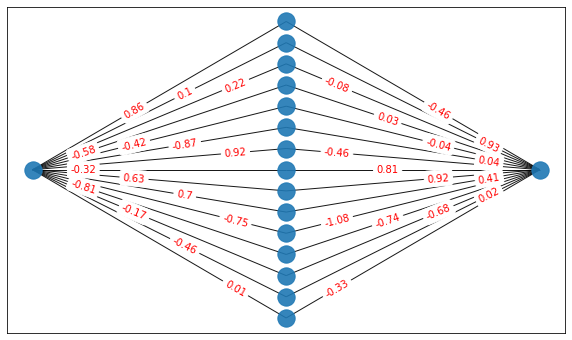

Epoch 21 out of 50 (40%)


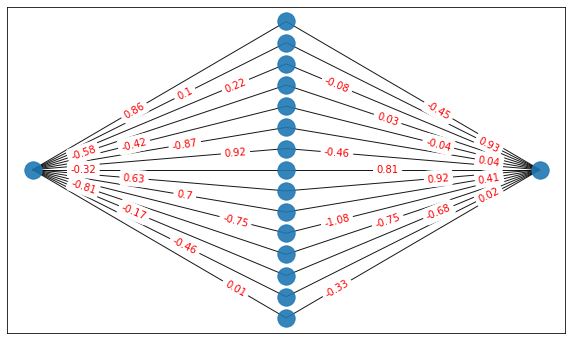

Epoch 22 out of 50 (42%)


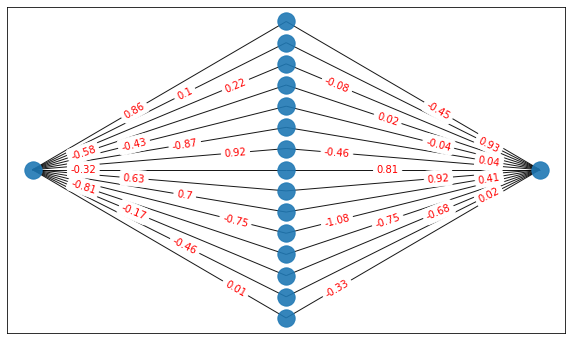

Epoch 23 out of 50 (44%)


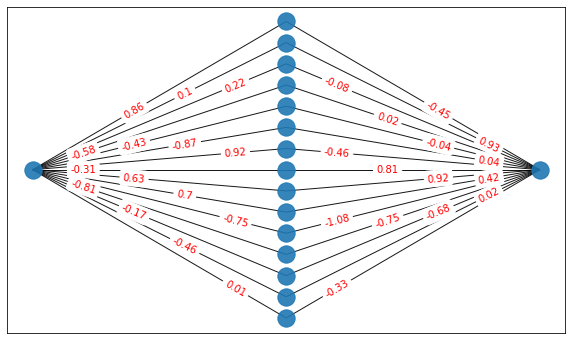

Epoch 24 out of 50 (46%)


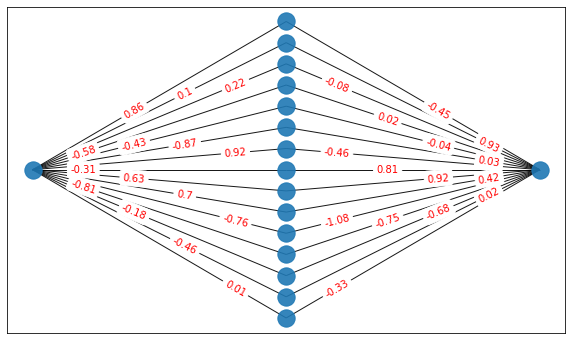

Epoch 25 out of 50 (48%)


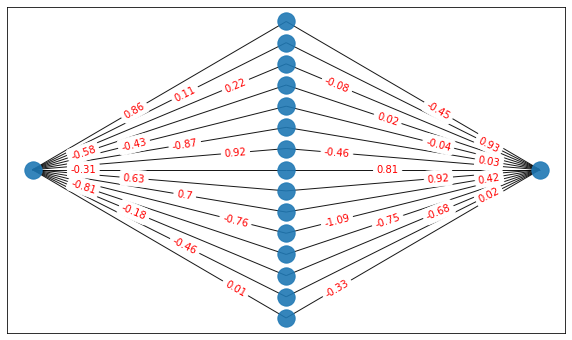

Epoch 26 out of 50 (50%)


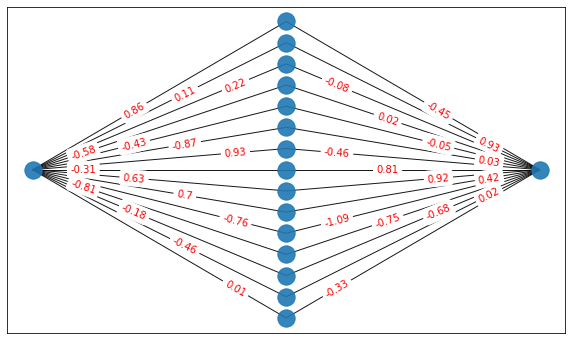

Epoch 27 out of 50 (52%)


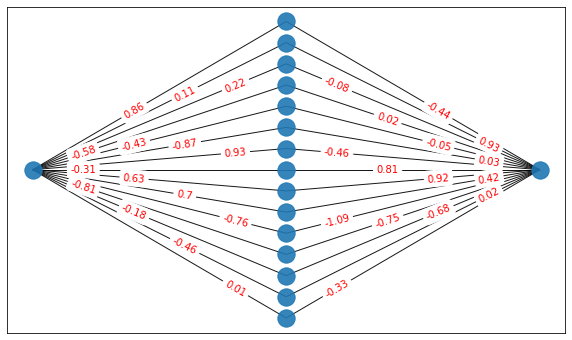

Epoch 28 out of 50 (54%)


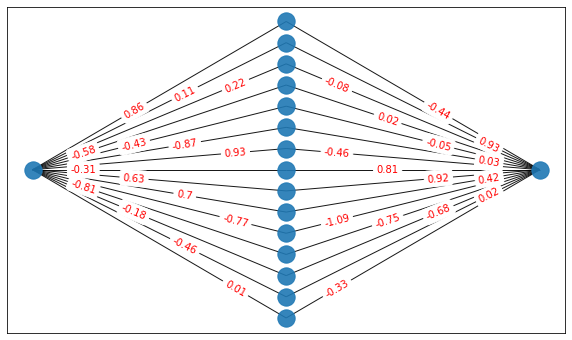

Epoch 29 out of 50 (56%)


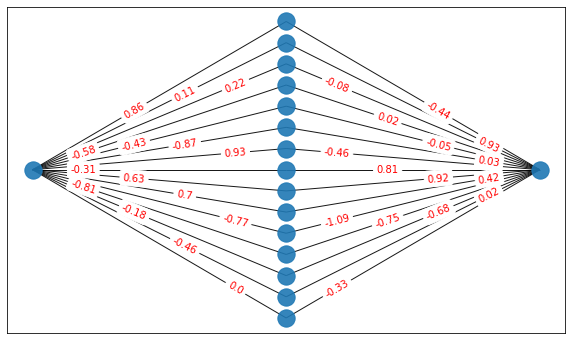

Epoch 30 out of 50 (58%)


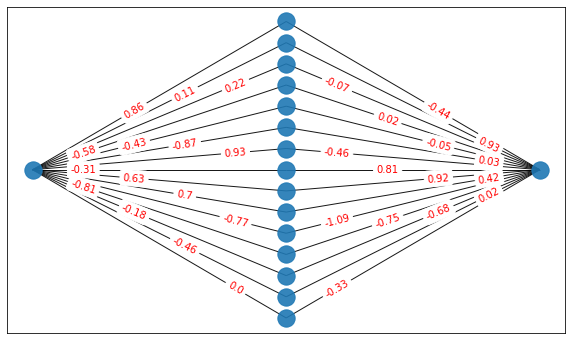

Epoch 31 out of 50 (60%)


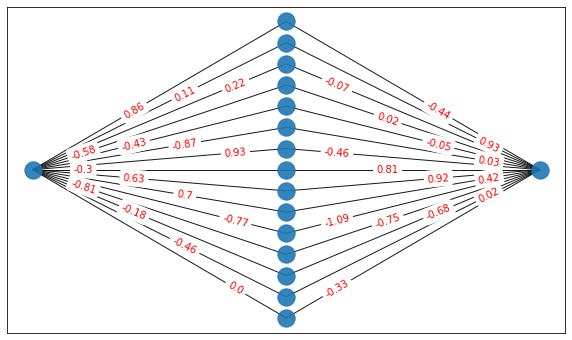

Epoch 32 out of 50 (62%)


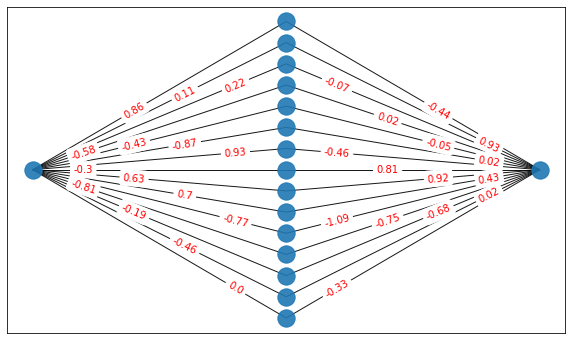

Epoch 33 out of 50 (64%)


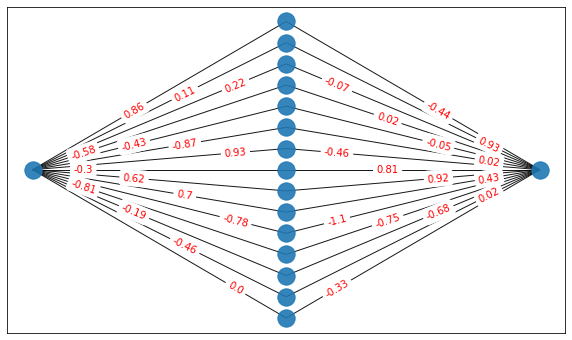

Epoch 34 out of 50 (66%)


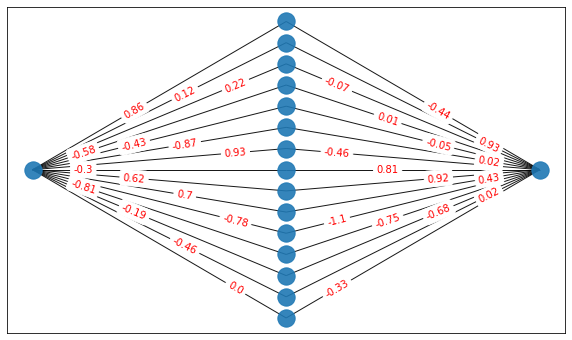

Epoch 35 out of 50 (68%)


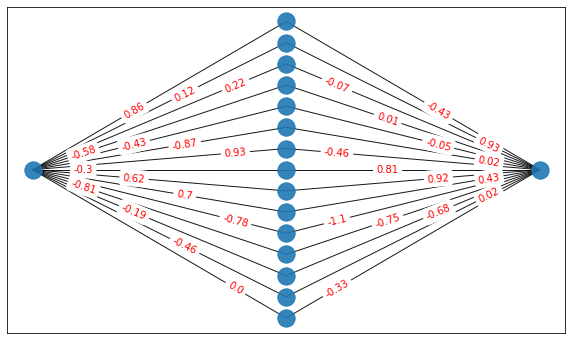

Epoch 36 out of 50 (70%)


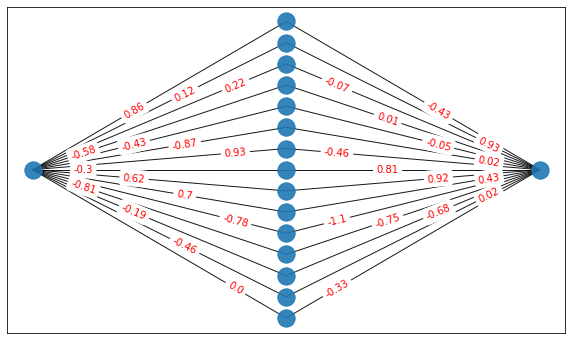

Epoch 37 out of 50 (72%)


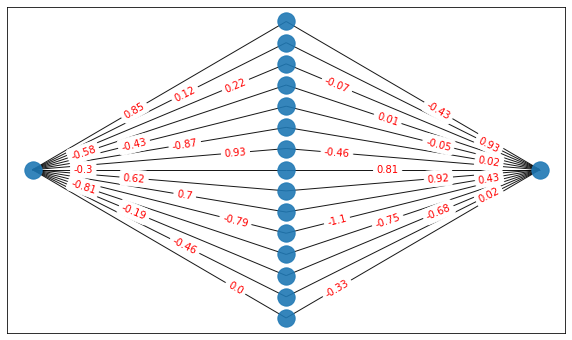

Epoch 38 out of 50 (74%)


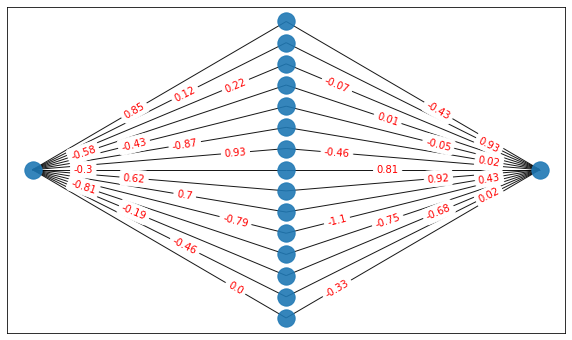

Epoch 39 out of 50 (76%)


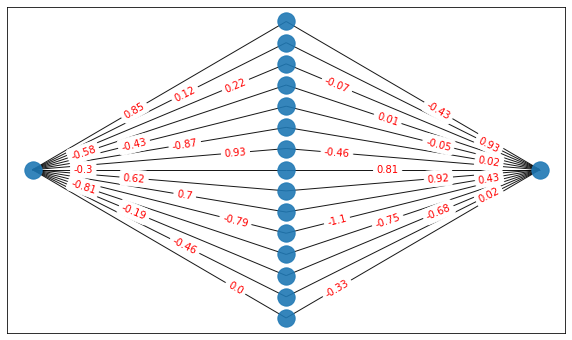

Epoch 40 out of 50 (78%)


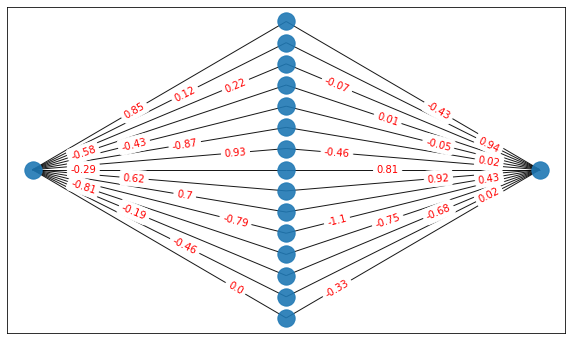

Epoch 41 out of 50 (80%)


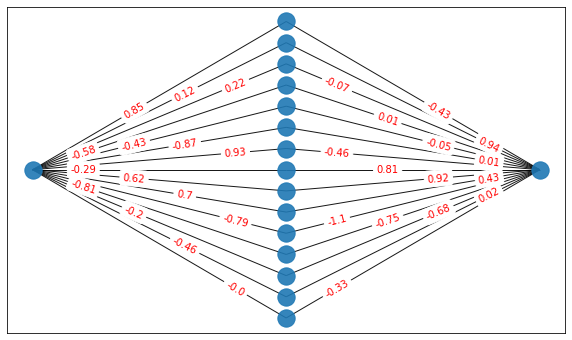

Epoch 42 out of 50 (82%)


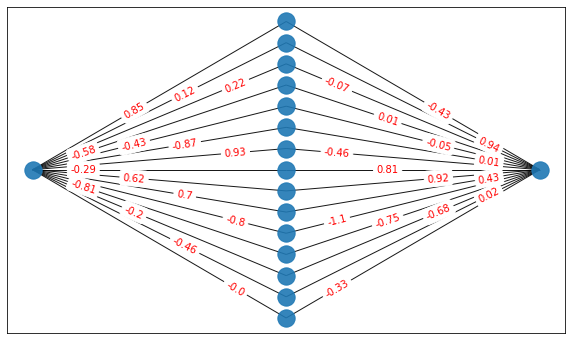

Epoch 43 out of 50 (84%)


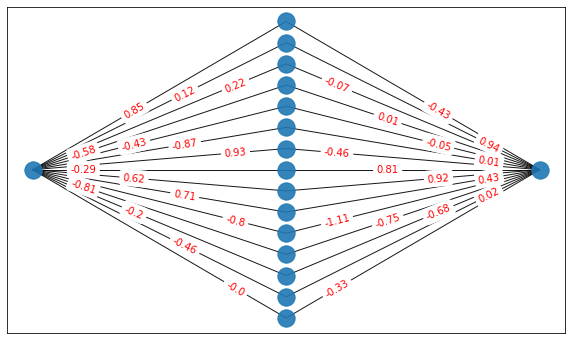

Epoch 44 out of 50 (86%)


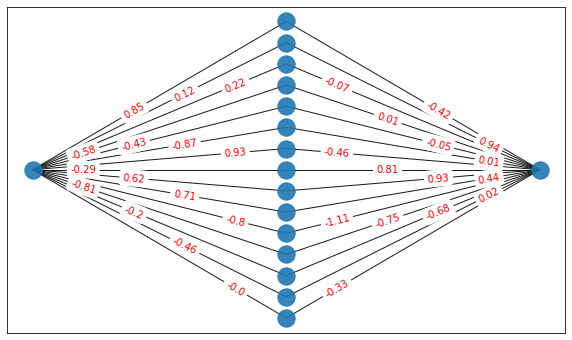

Epoch 45 out of 50 (88%)


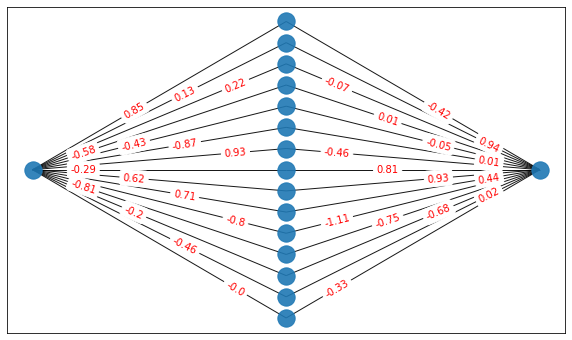

Epoch 46 out of 50 (90%)


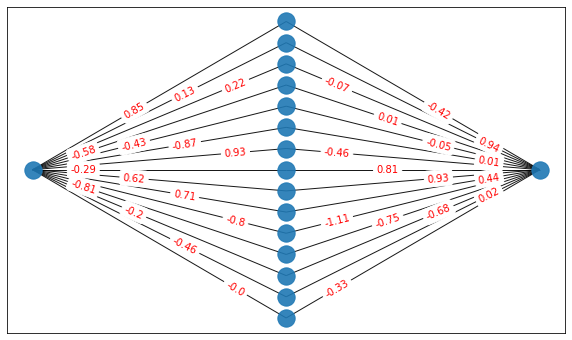

Epoch 47 out of 50 (92%)


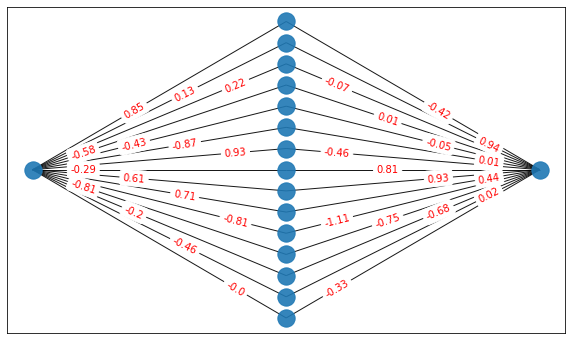

Epoch 48 out of 50 (94%)


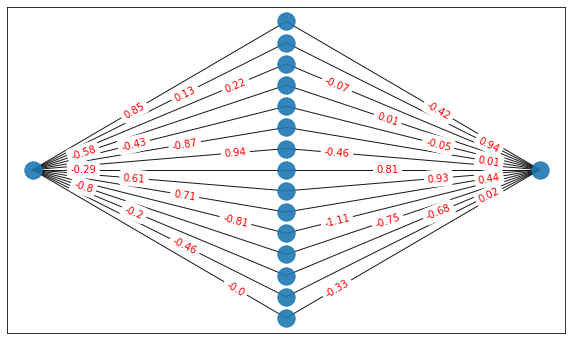

Epoch 49 out of 50 (96%)


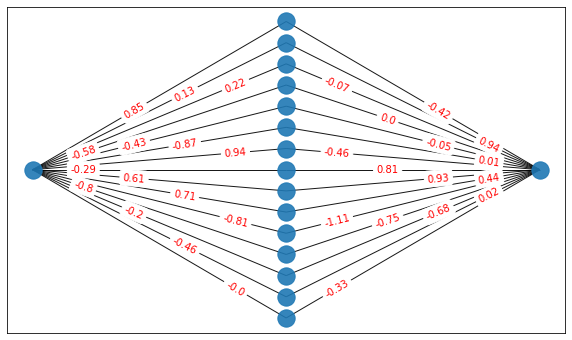

Epoch 50 out of 50 (98%)


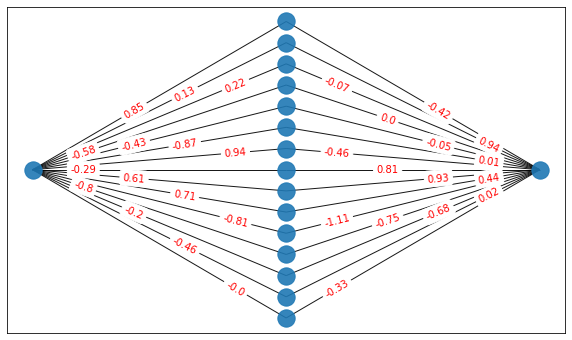

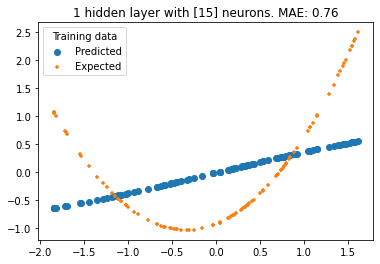

In [8]:
hidden_layers = [15]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data, learning_rate=0.005, epochs = 50, batch_size = 10, plot = True)
plt.scatter(scaled_train_df[:, 0], y_pred.reshape(-1, 1), label = 'Predicted')
plt.scatter(scaled_train_df[:, 0], scaled_train_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Training data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_pred, scaled_train_df[:, 1]), 2)}')
plt.show()

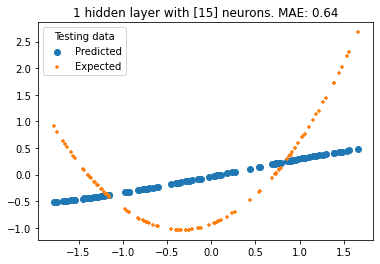

In [13]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

Niestety, wizualizacja może i fajnie wygląda, jednak znacząco wydłuża czas obliczeń, wobec czego trudniej o dobre wyniki.

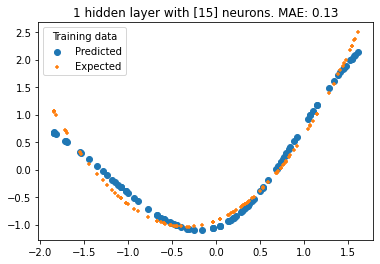

In [14]:
hidden_layers = [15]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data, learning_rate=0.005, epochs = 800, batch_size = 5, plot = False, verbose=False)
plt.scatter(scaled_train_df[:, 0], y_pred.reshape(-1, 1), label = 'Predicted')
plt.scatter(scaled_train_df[:, 0], scaled_train_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Training data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_pred, scaled_train_df[:, 1]), 2)}')
plt.show()

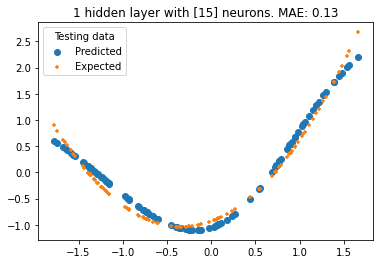

In [15]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

## Porównanie szybkości uczenia przy zastosowaniu podejścia batchowego i nie:

* Podejście batchowe - dane podzielone na 10-elementowe paczki, 700 epok:

In [16]:
hidden_layers = [15]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
%timeit -r 5 nn.train(train_data, learning_rate=0.005, epochs = 700, batch_size = 10, plot = False, verbose = False)

1.76 s ± 15.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


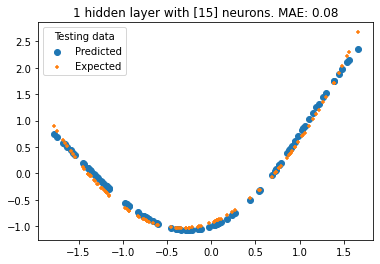

In [17]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

* Podejście bezbatchowe - dane de facto jednym stuelementowym batchem

In [18]:
hidden_layers = [15]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
%timeit -r 5 nn.train(train_data, learning_rate=0.005, epochs = 700, batch_size = 100, plot = False, verbose = False)

277 ms ± 4.31 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


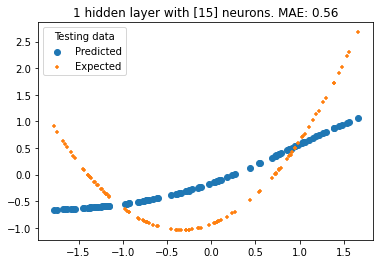

In [19]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

Oczywiście podejście bezbatchowe jest znacznie szybsze - w trakcie każdej z epok nie jest realizowane dziesięć iteracji wokół danych. Z powodu mniejszej liczby pętli, wyniki uzyskane przez sieć są jednocześnie znacznie gorsze. Jak wyjdzie porównanie czasu i wyniku gdy liczba iteracji będzie taka sama przy zachowaniu podejścia bezbatchowego? (epochs = 7000):

In [20]:
hidden_layers = [15]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
%timeit -r 5 nn.train(train_data, learning_rate=0.005, epochs = 7000, batch_size = 100, plot = False, verbose = False)

2.82 s ± 40.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


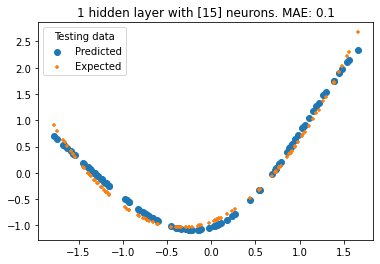

In [21]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

Czas działania funkcji był znacznie, niemal o 50% dłuższy niż w pierwszym przypadku. Niemniej jednak uzyskany wynik na danych testowych był lepszy aniżeli wcześniej.

## Porównanie metod inicjalizacji wag przy uczeniu z niewielką liczbą epok:
Ponieważ najprawdopodobniej niezależnie od wyboru metody losowania wag, sieć w końcu dojdzie do optymalnego ustawienia, sprawdźmy jakie wyniki osiągną modele z niewielką liczbą epok przy trenowaniu.
* Metoda He - losowanie z rozkładu normalnego ze średnią równą 0 i wariancją równą 2/n, gdzie n - rozmiar danych:

In [22]:
hidden_layers = [8, 7]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "He")
%timeit -r 5 nn.train(train_data, learning_rate=0.005, epochs = 200, batch_size = 100, plot = False, verbose = False)

106 ms ± 1.1 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


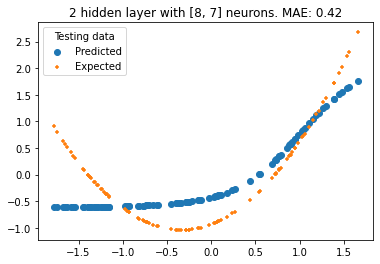

In [23]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

* Metoda Xaviera - losowanie z rozkładu jednostajnego na odcinku (-1/sqrt(n), 1/sqrt(n)), gdzie n - rozmiar danych:

In [24]:
hidden_layers = [8, 7]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Xavier")
%timeit -r 5 nn.train(train_data, learning_rate=0.005, epochs = 200, batch_size = 100, plot = False, verbose = False)

106 ms ± 1.38 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


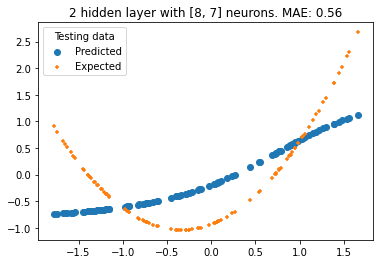

In [25]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

* Losowanie wag z rozkładu jednostajnego na przedziale (-1, 1):

In [26]:
hidden_layers = [8, 7]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
%timeit -r 5 nn.train(train_data, learning_rate=0.005, epochs = 200, batch_size = 100, plot = False, verbose = False)

107 ms ± 2.31 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


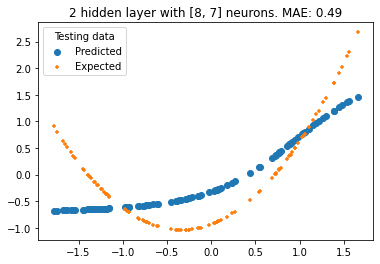

In [27]:
y_test_pred = nn.predict(scaled_test_df[:, 0].reshape(-1, 1))
plt.scatter(scaled_test_df[:, 0], y_test_pred, label = 'Predicted')
plt.scatter(scaled_test_df[:, 0], scaled_test_df[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, scaled_test_df[:, 1]), 2)}')
plt.show()

Przy 200 epokach najniższą wartość średniego błędu absolutnego przyniosła metoda He.

# Drugi zbiór danych:

In [28]:
steps_train = pd.read_csv('../dane/mio1/regression/steps-small-training.csv', index_col=0)
steps_test = pd.read_csv('../dane/mio1/regression/steps-small-test.csv', index_col=0)
train_data_step = np.array([
    np.array([[x_i], [y_i]])
    for x_i, y_i in zip(
        steps_train['x'].values,
        steps_train['y'].values
    )
])

In [29]:
len(y_pred)

100

Epoch 1 out of 900 (0%)
Epoch 2 out of 900 (0%)
Epoch 3 out of 900 (0%)
Epoch 4 out of 900 (0%)
Epoch 5 out of 900 (0%)
Epoch 6 out of 900 (1%)
Epoch 7 out of 900 (1%)
Epoch 8 out of 900 (1%)
Epoch 9 out of 900 (1%)
Epoch 10 out of 900 (1%)
Epoch 11 out of 900 (1%)
Epoch 12 out of 900 (1%)
Epoch 13 out of 900 (1%)
Epoch 14 out of 900 (1%)
Epoch 15 out of 900 (2%)
Epoch 16 out of 900 (2%)
Epoch 17 out of 900 (2%)
Epoch 18 out of 900 (2%)
Epoch 19 out of 900 (2%)
Epoch 20 out of 900 (2%)
Epoch 21 out of 900 (2%)
Epoch 22 out of 900 (2%)
Epoch 23 out of 900 (2%)
Epoch 24 out of 900 (3%)
Epoch 25 out of 900 (3%)
Epoch 26 out of 900 (3%)
Epoch 27 out of 900 (3%)
Epoch 28 out of 900 (3%)
Epoch 29 out of 900 (3%)
Epoch 30 out of 900 (3%)
Epoch 31 out of 900 (3%)
Epoch 32 out of 900 (3%)
Epoch 33 out of 900 (4%)
Epoch 34 out of 900 (4%)
Epoch 35 out of 900 (4%)
Epoch 36 out of 900 (4%)
Epoch 37 out of 900 (4%)
Epoch 38 out of 900 (4%)
Epoch 39 out of 900 (4%)
Epoch 40 out of 900 (4%)
Epoch 41 

Epoch 315 out of 900 (35%)
Epoch 316 out of 900 (35%)
Epoch 317 out of 900 (35%)
Epoch 318 out of 900 (35%)
Epoch 319 out of 900 (35%)
Epoch 320 out of 900 (35%)
Epoch 321 out of 900 (36%)
Epoch 322 out of 900 (36%)
Epoch 323 out of 900 (36%)
Epoch 324 out of 900 (36%)
Epoch 325 out of 900 (36%)
Epoch 326 out of 900 (36%)
Epoch 327 out of 900 (36%)
Epoch 328 out of 900 (36%)
Epoch 329 out of 900 (36%)
Epoch 330 out of 900 (37%)
Epoch 331 out of 900 (37%)
Epoch 332 out of 900 (37%)
Epoch 333 out of 900 (37%)
Epoch 334 out of 900 (37%)
Epoch 335 out of 900 (37%)
Epoch 336 out of 900 (37%)
Epoch 337 out of 900 (37%)
Epoch 338 out of 900 (37%)
Epoch 339 out of 900 (38%)
Epoch 340 out of 900 (38%)
Epoch 341 out of 900 (38%)
Epoch 342 out of 900 (38%)
Epoch 343 out of 900 (38%)
Epoch 344 out of 900 (38%)
Epoch 345 out of 900 (38%)
Epoch 346 out of 900 (38%)
Epoch 347 out of 900 (38%)
Epoch 348 out of 900 (39%)
Epoch 349 out of 900 (39%)
Epoch 350 out of 900 (39%)
Epoch 351 out of 900 (39%)
E

Epoch 643 out of 900 (71%)
Epoch 644 out of 900 (71%)
Epoch 645 out of 900 (72%)
Epoch 646 out of 900 (72%)
Epoch 647 out of 900 (72%)
Epoch 648 out of 900 (72%)
Epoch 649 out of 900 (72%)
Epoch 650 out of 900 (72%)
Epoch 651 out of 900 (72%)
Epoch 652 out of 900 (72%)
Epoch 653 out of 900 (72%)
Epoch 654 out of 900 (73%)
Epoch 655 out of 900 (73%)
Epoch 656 out of 900 (73%)
Epoch 657 out of 900 (73%)
Epoch 658 out of 900 (73%)
Epoch 659 out of 900 (73%)
Epoch 660 out of 900 (73%)
Epoch 661 out of 900 (73%)
Epoch 662 out of 900 (73%)
Epoch 663 out of 900 (74%)
Epoch 664 out of 900 (74%)
Epoch 665 out of 900 (74%)
Epoch 666 out of 900 (74%)
Epoch 667 out of 900 (74%)
Epoch 668 out of 900 (74%)
Epoch 669 out of 900 (74%)
Epoch 670 out of 900 (74%)
Epoch 671 out of 900 (74%)
Epoch 672 out of 900 (75%)
Epoch 673 out of 900 (75%)
Epoch 674 out of 900 (75%)
Epoch 675 out of 900 (75%)
Epoch 676 out of 900 (75%)
Epoch 677 out of 900 (75%)
Epoch 678 out of 900 (75%)
Epoch 679 out of 900 (75%)
E

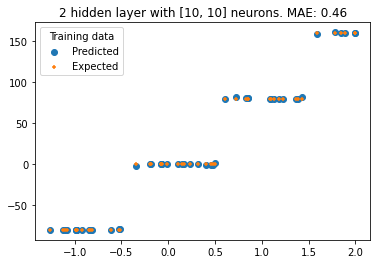

In [30]:
hidden_layers = [10, 10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data_step, learning_rate=0.01, epochs = 900, batch_size = 5, plot = False)
plt.scatter(train_data_step[:, 0], y_pred.reshape(-1, 1), label = 'Predicted')
plt.scatter(train_data_step[:, 0], train_data_step[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Training data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_pred, train_data_step[:, 1]), 2)}')
plt.show()

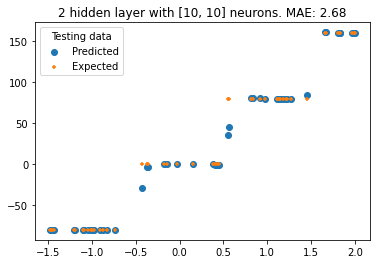

In [31]:
y_test_pred = nn.predict(steps_test['x'].values.reshape(-1, 1))
plt.scatter(steps_test['x'].values, y_test_pred, label = 'Predicted')
plt.scatter(steps_test['x'].values, steps_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, steps_test.iloc[:,1].values), 2)}')
plt.show()

Błąd osiągnięty na zbiorze testowym jest znacznie wyższy od błędu na zbiorze treningowym. Analizując powyyższy wykres można odnieść wrażenie, że sieć nie została wystarczająco dopasowana.

In [32]:
%%timeit -r 3
nn = Net(n_inputs=1, hidden_neurons_n=[10], n_outputs=1, weights="Uniform",
         hidden_activation_fun=sigmoid, last_activation_fun=lambda x: x)
y_pred = nn.train(train_data, learning_rate=0.005, epochs = 250, batch_size = 5, plot = False, verbose = False)

1.12 s ± 5.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [33]:
%%timeit -r 3
nn = Net(n_inputs=1, hidden_neurons_n=[10], n_outputs=1, weights="Uniform",
         hidden_activation_fun=sigmoid, last_activation_fun=lambda x: x)
y_pred = nn.train(train_data, learning_rate=0.005, epochs = 250, batch_size = 1000, plot = False, verbose = False)

84.3 ms ± 771 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## Porównanie metod inicjalizacji wag:
Podobnie jak wcześniej, sprawdźmy jaki wpływ na wyniki ma metoda inicjalizacji wag.

* Metoda He:

In [40]:
hidden_layers = [10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "He")
y_pred = nn.train(train_data_step, learning_rate=0.01, epochs = 300, batch_size = 5, plot = False, verbose = False)

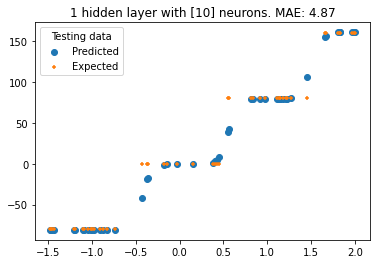

In [41]:
y_test_pred = nn.predict(steps_test['x'].values.reshape(-1, 1))
plt.scatter(steps_test['x'].values, y_test_pred, label = 'Predicted')
plt.scatter(steps_test['x'].values, steps_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, steps_test.iloc[:,1].values), 2)}')
plt.show()

* Metoda Xaviera:

In [42]:
hidden_layers = [10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Xavier")
y_pred = nn.train(train_data_step, learning_rate=0.01, epochs = 300, batch_size = 5, plot = False, verbose = False)

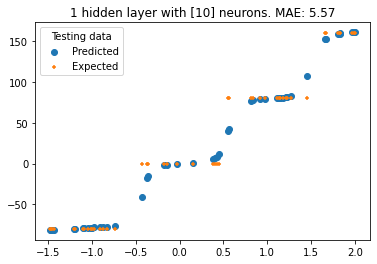

In [43]:
y_test_pred = nn.predict(steps_test['x'].values.reshape(-1, 1))
plt.scatter(steps_test['x'].values, y_test_pred, label = 'Predicted')
plt.scatter(steps_test['x'].values, steps_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, steps_test.iloc[:,1].values), 2)}')
plt.show()

* Rozkład jednostajny (-1, 1):

In [44]:
hidden_layers = [10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data_step, learning_rate=0.01, epochs = 300, batch_size = 5, plot = False, verbose = False)

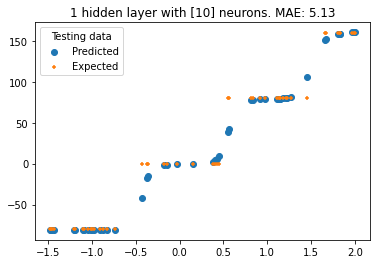

In [45]:
y_test_pred = nn.predict(steps_test['x'].values.reshape(-1, 1))
plt.scatter(steps_test['x'].values, y_test_pred, label = 'Predicted')
plt.scatter(steps_test['x'].values, steps_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, steps_test.iloc[:,1].values), 2)}')
plt.show()

Tym razem, najlepszy wynik osiagnięto przy metodzie Xaviera. Wartość nie odbiegła jednak znacząco od metody He.

# Trzeci zbiór danych - multimodal-large

In [46]:
multi_train = pd.read_csv('../dane/mio1/regression/multimodal-large-training.csv', index_col=0)
multi_test = pd.read_csv('../dane/mio1/regression/multimodal-large-test.csv', index_col=0)
train_data_multi = np.array([
    np.array([[x_i], [y_i]])
    for x_i, y_i in zip(
        multi_train['x'].values,
        multi_train['y'].values
    )

])

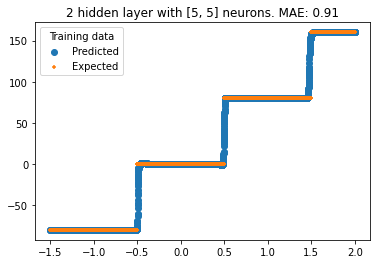

In [47]:
hidden_layers = [5, 5]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data_multi, learning_rate=0.01, epochs = 900, batch_size = 100, plot = False, verbose = False)
plt.scatter(train_data_multi[:, 0], y_pred.reshape(-1, 1), label = 'Predicted')
plt.scatter(train_data_multi[:, 0], train_data_multi[:, 1], label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Training data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_pred, train_data_multi[:, 1]), 2)}')
plt.show()

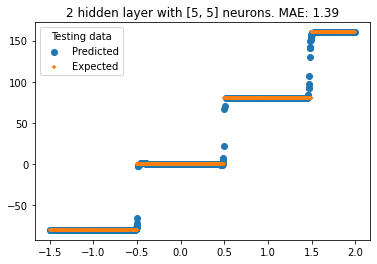

In [48]:
y_test_pred = nn.predict(multi_test['x'].values.reshape(-1, 1))
plt.scatter(multi_test['x'].values, y_test_pred, label = 'Predicted', )
plt.scatter(multi_test['x'].values, multi_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, multi_test.iloc[:,1].values), 2)}')
plt.show()

## Porównanie metod inicjalizacji wag:

* Metoda He:

In [55]:
hidden_layers = [10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "He")
y_pred = nn.train(train_data_multi, learning_rate=0.01, epochs = 300, batch_size = 100, plot = False, verbose = False)

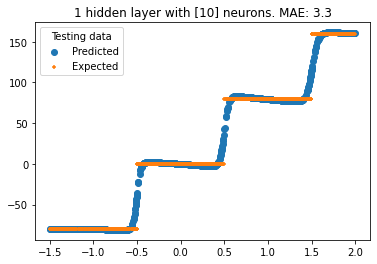

In [56]:
y_test_pred = nn.predict(multi_test['x'].values.reshape(-1, 1))
plt.scatter(multi_test['x'].values, y_test_pred, label = 'Predicted', )
plt.scatter(multi_test['x'].values, multi_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, multi_test.iloc[:,1].values), 2)}')
plt.show()

* Metoda Xaviera:

In [57]:
hidden_layers = [10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Xavier")
y_pred = nn.train(train_data_multi, learning_rate=0.01, epochs = 300, batch_size = 100, plot = False, verbose = False)

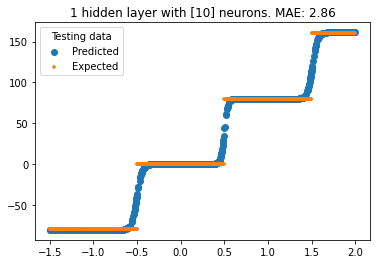

In [58]:
y_test_pred = nn.predict(multi_test['x'].values.reshape(-1, 1))
plt.scatter(multi_test['x'].values, y_test_pred, label = 'Predicted', )
plt.scatter(multi_test['x'].values, multi_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, multi_test.iloc[:,1].values), 2)}')
plt.show()

* Rozkład jednostajny (-1, 1):

In [59]:
hidden_layers = [10]

nn = Net(n_inputs = 1, hidden_neurons_n=hidden_layers, n_outputs=1, hidden_activation_fun=sigmoid,
         last_activation_fun=lambda x: x, weights = "Uniform")
y_pred = nn.train(train_data_multi, learning_rate=0.01, epochs = 300, batch_size = 100, plot = False, verbose = False)

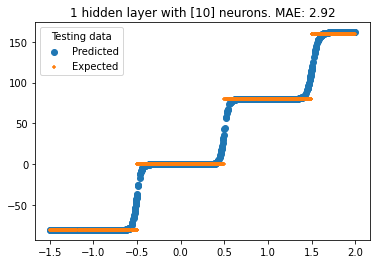

In [60]:
y_test_pred = nn.predict(multi_test['x'].values.reshape(-1, 1))
plt.scatter(multi_test['x'].values, y_test_pred, label = 'Predicted', )
plt.scatter(multi_test['x'].values, multi_test['y'].values, label = 'Expected', marker = '+', s = 10)
plt.legend(title = 'Testing data')
plt.title(f'{len(hidden_layers)} hidden layer with {hidden_layers} neurons. MAE: {round(metrics.mean_absolute_error(y_test_pred, multi_test.iloc[:,1].values), 2)}')
plt.show()

W tej próbie ponownie najlepiej dopasowały się sieci po skorzystaniu z metod He i Xaviera.

# Podsumowanie

Podejście batchowe negatywnie wpływa na szybkość uczenia przy tej samej liczbie epok. Jest to zrozumiałe - w przypadku zastosowania go, liczba iteracji znacznie wzrasta. Ponadto, częściej zmieniane są wartości wag w sieci. Jeśli chodzi o najlepszy sposób inicjalizacji wag, to nazwane na cześć He oraz Xaviera metody przynoszą najlepszy efekt w trakcie trenowania sieci.
